In [1]:
%matplotlib inline

In [2]:
import arviz as az

In [3]:
from util import stan_cache

In [4]:
np.random.seed(1)

In [5]:
mu, sigma = 3., 1.

In [6]:
sample = np.random.lognormal(mu, sigma, 1000) + 1

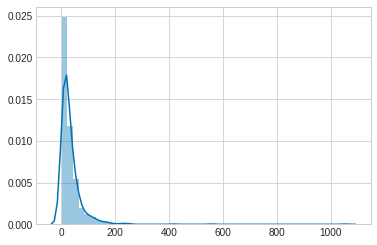

In [7]:
sns.distplot(sample)

In [8]:
pd.Series(sample).to_frame().describe().T

,count,mean,std,min,25%,50%,75%,max
0,1000.0,34.926502,50.866295,1.947655,12.021408,21.932291,41.609927,1053.162347


## pareto

In [9]:
pareto = """
data {
    int<lower=0> N;
    real<lower=1.0> x[N];
    real<lower=0> minx;
}
parameters {
    real<lower=0.0001,upper=minx> alpha;
    real<lower=0.0001> beta; 
}
model {
    x ~ pareto(alpha, beta);
}
generated quantities{
    vector[N] log_lik;

    for(n in 1:N){
        log_lik[n] = pareto_lpdf(x[n] | alpha, beta);
    }
}
"""

In [10]:
data = {
    'N': len(sample),
    'x':  sample,
    'minx': 0.1
}

sm1 = stan_cache(model_code=pareto)
params1 = sm1.sampling(data=data, iter=6000, warmup=2000)

In [11]:
pd.DataFrame({'mu': params1['alpha'], 'sigma': params1['beta']}).describe().T

,count,mean,std,min,25%,50%,75%,max
mu,16000.0,0.099460,0.000531,0.095323,0.099257,0.099616,0.099837,0.100000
sigma,16000.0,0.184786,0.005842,0.162507,0.180788,0.184710,0.188694,0.211295


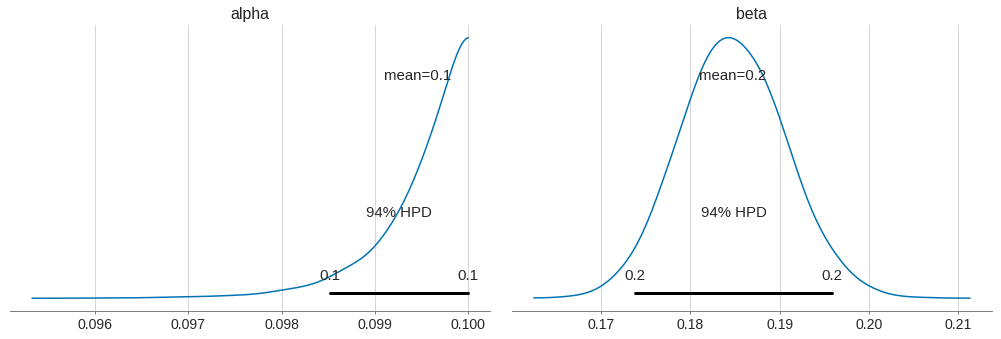

In [12]:
az.plot_posterior(params1, var_names=['alpha', 'beta']);

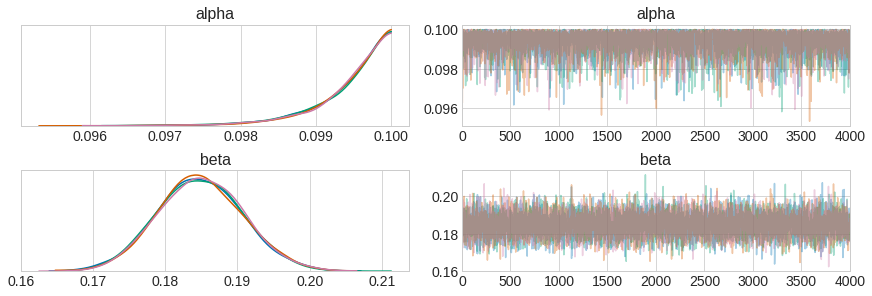

In [13]:
az.plot_trace(params1, var_names=('alpha', 'beta'));

## log_normal

In [14]:
log_normal = """
data {
    int<lower=0> N;
    real<lower=0.999> x[N];
}
parameters {
    real mu;  
    real<lower=0> sigma;
}
model {
    x ~ lognormal(mu,sigma);
}
generated quantities{
    vector[N] log_lik;

    for(i in 1:N){
        log_lik[i] = lognormal_lpdf(x[i] | mu, sigma);
    }
}
"""

In [15]:
data = {
    'N': len(sample),
    'x':  sample
}

sm2 = stan_cache(model_code=log_normal)
params2 = sm2.sampling(data=data, iter=6000, warmup=2000)

In [16]:
pd.DataFrame({'mu': params2['mu'], 'sigma': params2['sigma']}).describe().T

,count,mean,std,min,25%,50%,75%,max
mu,16000.0,3.111313,0.028914,3.000168,3.091745,3.111333,3.130916,3.218855
sigma,16000.0,0.915172,0.020389,0.831627,0.901281,0.914914,0.928866,1.014603


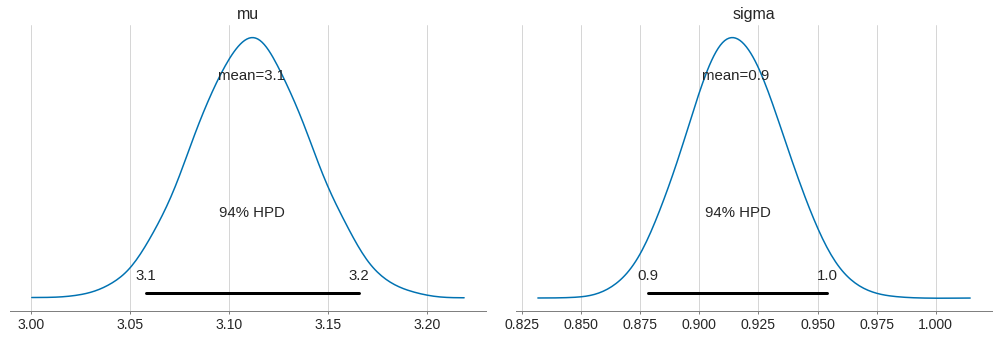

In [17]:
az.plot_posterior(params2, var_names=['mu', 'sigma']);

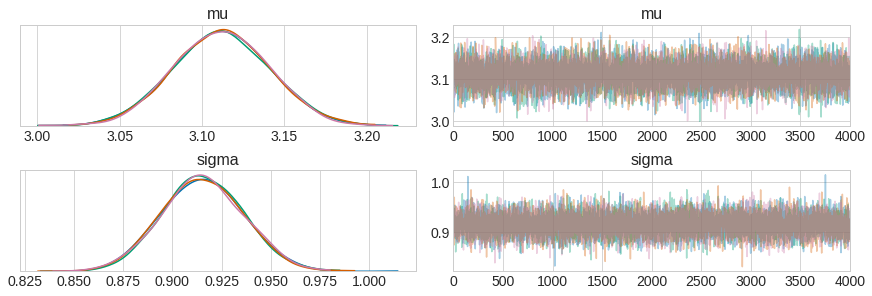

In [18]:
az.plot_trace(params2, var_names=('mu', 'sigma'));

## gamma

In [19]:
gamma = """
data {
    int<lower=0> N;
    real<lower=0.999> x[N];
}
parameters {
    real<lower=0.0001> alpha;
    real<lower=0.0001> beta;
}
model {
    x ~ gamma(alpha, beta);
}
generated quantities{
    vector[N] log_lik;

    for(i in 1:N){
        log_lik[i] = gamma_lpdf(x[i] | alpha, beta);
    }
}
"""

In [20]:
data = {
    'N': len(sample),
    'x':  sample
}

sm3 = stan_cache(model_code=gamma)
params3 = sm3.sampling(data=data, iter=6000, warmup=2000)

In [21]:
pd.DataFrame({'alpha': params3['alpha'], 'beta': params3['beta']}).describe().T

,count,mean,std,min,25%,50%,75%,max
alpha,16000.0,1.273038,0.050670,1.051826,1.238223,1.271737,1.306640,1.514228
beta,16000.0,0.036463,0.001776,0.029091,0.035245,0.036412,0.037633,0.044155


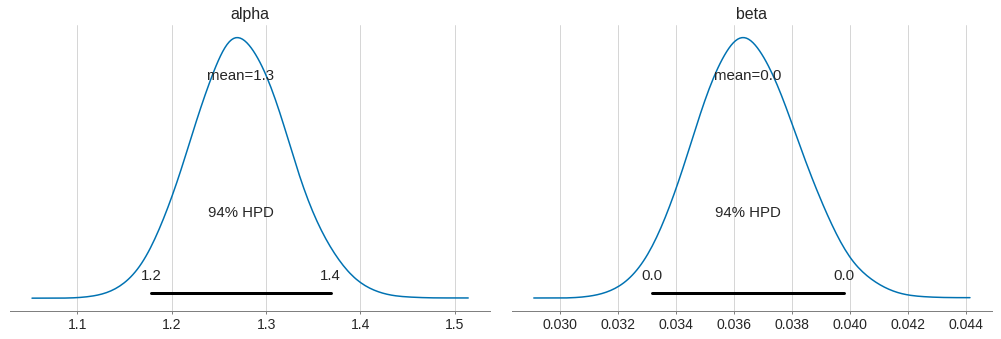

In [22]:
az.plot_posterior(params3, var_names=['alpha', 'beta']);

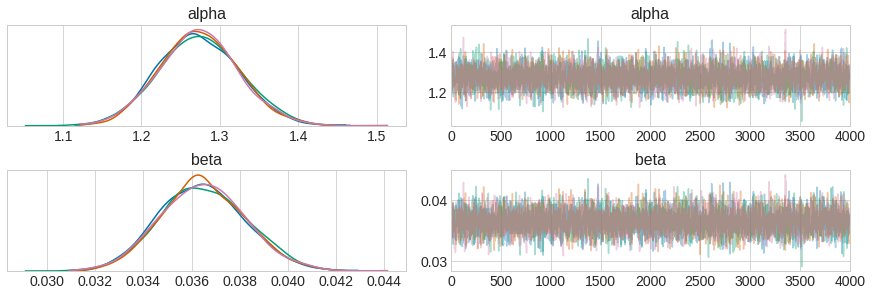

In [23]:
az.plot_trace(params3, var_names=('alpha', 'beta'));

## WBIC

In [24]:
def wbic(log_likelihood):
    return - np.mean(np.sum(log_likelihood, axis=1))

In [25]:
pd.Series({
    "pareto": wbic(params1['log_lik']),
    "log_normal": wbic(params2['log_lik']),
    "gamma": wbic(params3['log_lik'])}
).to_frame().rename(columns={0: "WBIC"}).T

,pareto,log_normal,gamma
WBIC,5801.184129,4440.708108,4537.560664


## WAIC

In [26]:
def waic(log_likelihood):
    training_error = - np.mean(np.log(np.mean(np.exp(log_likelihood), axis=0)))
    functional_variance_div_N = np.mean((np.mean(log_likelihood**2, axis=0)) - np.mean(log_likelihood)**2)
    return training_error + functional_variance_div_N

In [27]:
pd.Series({
    "pareto": waic(params1['log_lik']),
    "log_normal": waic(params2['log_lik']),
    "gamma": waic(params3['log_lik'])}
).to_frame().rename(columns={0: "WAIC"}).T

,pareto,log_normal,gamma
WAIC,6.973606,5.916227,7.395654
